In this notebook, we present various usecases to interact with ptype to handle missing type predictions.

In [6]:
# Preamble to run notebook in context of source package.
# NBVAL_IGNORE_OUTPUT
import sys
sys.path.insert(0, '../')

In [7]:
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcdefaults()

from ptype.Ptype import Ptype
from ptype.utils import evaluate_types
import pandas as pd
import numpy as np
from utils import *

In [8]:
ptype = Ptype()

# 1. Incorrect missing data prediction

In [9]:
df = read_data(dataset_name='auto')
column = 0
df_subsample = subsample_df(df, column_to_sample_from = column, sample_num = 10)
df_subsample

,0
78,2
97,1
151,1
44,1
40,0
67,-1
98,2
18,2
152,1
62,0


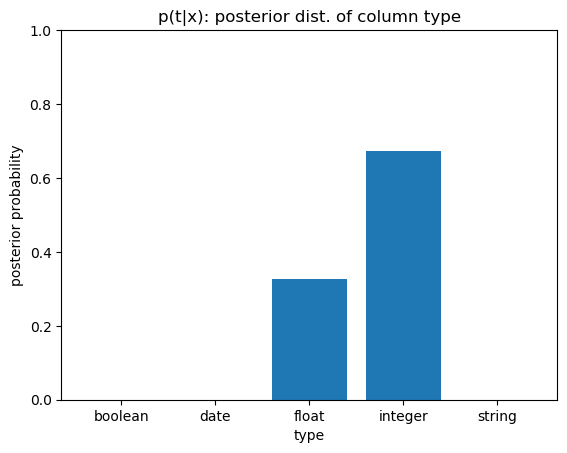

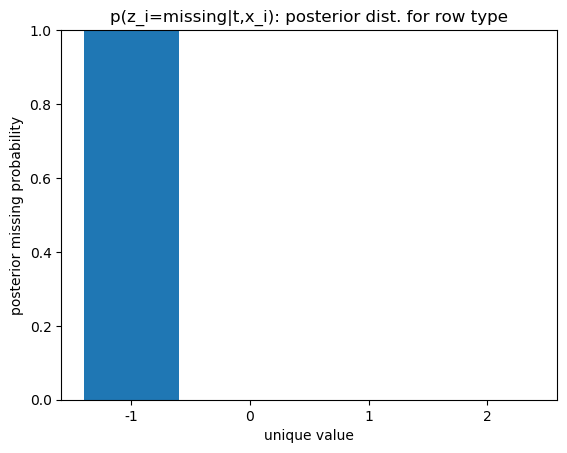

In [10]:
ptype.fit_schema(df_subsample)

plot_column_type_posterior(ptype.cols[column].p_t)

plot_row_type_posterior(ptype.cols[column], t='missing')

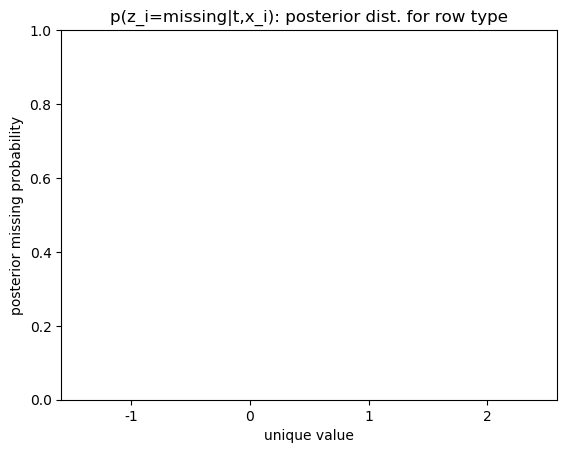

In [11]:
ptype.cols[column].reclassify_normal(['-1'])

plot_row_type_posterior(ptype.cols[column], t='missing')

# 2. Multiple missing data encodings

,LRE Ages 3-5 - Full Incl #
3085,
2398,
2579,
1776,
3,16
136,38
700,-
1578,
1964,
457,-


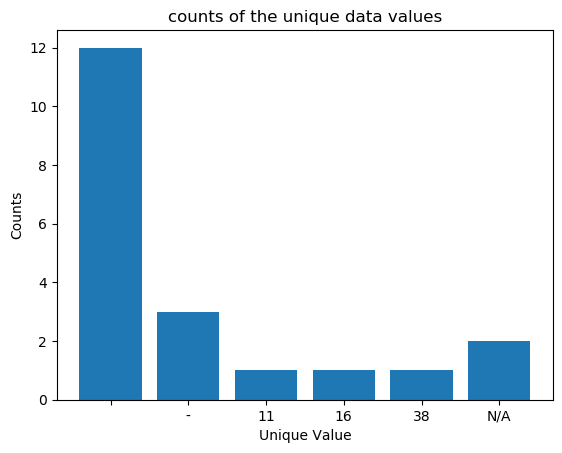

In [12]:
df = read_data("mass_6", header=0)

column = "LRE Ages 3-5 - Full Incl #"
df_subsample = subsample_df(df, column_to_sample_from=column, sample_num=20)
display(df_subsample)

unique_values, counts = np.unique(
    [str(v) for v in df_subsample[column].tolist()],
    return_counts=True,
)
plot_bar(
    unique_values,
    counts,
    title="counts of the unique data values",
    y_lim_max=None,
    xlabel="Unique Value",
    ylabel="Counts",
)

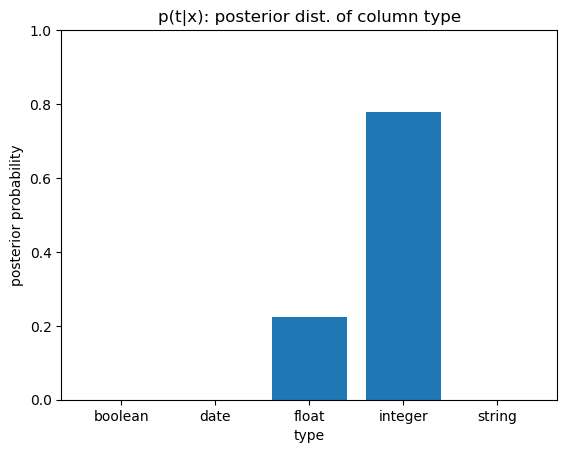

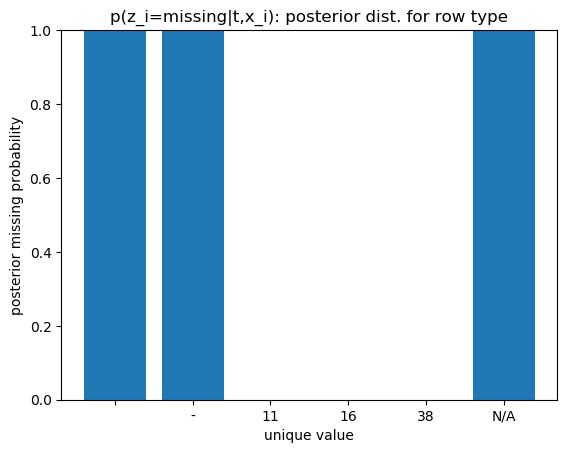

In [13]:
ptype.fit_schema(df_subsample)
col = ptype.cols[column]

plot_column_type_posterior(col.p_t)

plot_row_type_posterior(col, t='missing')

In [15]:
col.get_missing_values()


['', '-', 'N/A']

In [16]:
new_encoding = 'NA'
for v in col.get_missing_values():
    col.series.replace(v, new_encoding, inplace=True)
col.series


3085    NA
2398    NA
2579    NA
1776    NA
3       16
136     38
700     NA
1578    NA
1964    NA
457     NA
1601    NA
2088    NA
1723    NA
1363    NA
2919    NA
1551    NA
630     NA
2515    NA
2455    NA
301     11
Name: LRE Ages 3-5 - Full Incl #, dtype: object

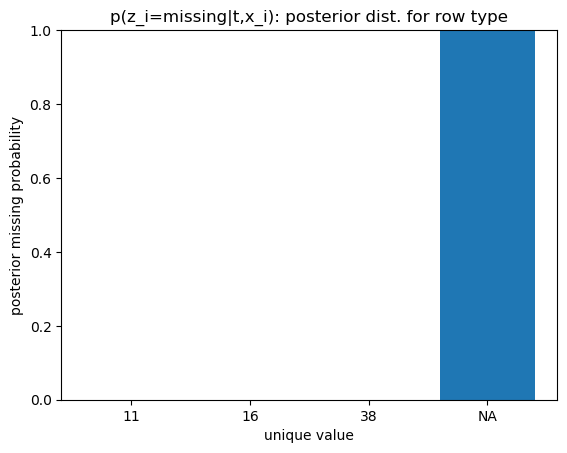

In [17]:
df_subsample[column] = col.series
ptype.fit_schema(df_subsample) # run ptype again
plot_row_type_posterior(ptype.cols[column], t='missing')